In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path

### Import data

In [2]:
df_Ch001 = pd.DataFrame(pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch001.pkl")))
df_Ch009 = pd.DataFrame(pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch009.pkl")))
df_Ch020 = pd.DataFrame(pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch020.pkl")))
df_Ch022 = pd.DataFrame(pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch022.pkl")))

### Split data

In [3]:
import torch

In [4]:
L=35
test_index = int(len(df_Ch022.index)*0.1)
val_index = int(len(df_Ch022.index)*0.2)

data_input = torch.tensor(np.vstack((df_Ch001.iloc[:,L].values, df_Ch009.iloc[:,L].values, df_Ch020.iloc[:,L].values)).T).float()
target = torch.tensor(df_Ch022.iloc[:,L].values[:,np.newaxis]).float()

data_input_train = data_input[val_index:]
target_train = target[val_index:]

data_input_val= data_input[:val_index]
target_val= target[:val_index]

data_input_test = data_input[:test_index]
target_test = target[:test_index]

print(data_input_train.shape, data_input_val.shape)

torch.Size([3777, 3]) torch.Size([944, 3])


In [5]:
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [6]:
trainset = TensorDataset(data_input_train, target_train)
train_loader = DataLoader(trainset, batch_size=3777)
validationset= TensorDataset(data_input_val, target_val)
val_loader = DataLoader(validationset, batch_size=472)

### ANN model

In [7]:
class ReLUNet(nn.Module):
    def __init__(self):
        super(ReLUNet, self).__init__()
        self.fc1 = nn.Linear(3, 40)
        self.fc2 = nn.Linear(40,1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Creating Model, Optimizer and Loss

In [8]:
# creating model,and defining optimizer and loss
model = ReLUNet()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

### Training and Evaluating using Ignite

In [9]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RunningAverage
from ignite.handlers import ModelCheckpoint, EarlyStopping

In [10]:
# defining the number of epochs
epochs = 100
# creating trainer,evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
metrics = {
    'MSE':Loss(criterion)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
training_history = {'loss':[]}
validation_history = {'loss':[]}
last_epoch = []

In [11]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

In [12]:
def score_function(engine):
    val_loss = engine.state.metrics['MSE']
    return -val_loss

handler = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

In [13]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    loss = metrics['MSE']
    last_epoch.append(0)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}  Avg loss: {:.2f}"
          .format(trainer.state.epoch, loss))

def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    loss = metrics['MSE']
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}  Avg loss: {:.2f}"
          .format(trainer.state.epoch, loss))
    
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)  

### Run Engine

In [14]:
trainer.run(train_loader, max_epochs=epochs)

Training Results - Epoch: 1  Avg loss: 1.04
Validation Results - Epoch: 1  Avg loss: 0.76
Training Results - Epoch: 2  Avg loss: 1.04
Validation Results - Epoch: 2  Avg loss: 0.76
Training Results - Epoch: 3  Avg loss: 1.03
Validation Results - Epoch: 3  Avg loss: 0.76
Training Results - Epoch: 4  Avg loss: 1.03
Validation Results - Epoch: 4  Avg loss: 0.76
Training Results - Epoch: 5  Avg loss: 1.03
Validation Results - Epoch: 5  Avg loss: 0.75
Training Results - Epoch: 6  Avg loss: 1.03
Validation Results - Epoch: 6  Avg loss: 0.75
Training Results - Epoch: 7  Avg loss: 1.03
Validation Results - Epoch: 7  Avg loss: 0.75
Training Results - Epoch: 8  Avg loss: 1.02
Validation Results - Epoch: 8  Avg loss: 0.75
Training Results - Epoch: 9  Avg loss: 1.02
Validation Results - Epoch: 9  Avg loss: 0.75
Training Results - Epoch: 10  Avg loss: 1.02
Validation Results - Epoch: 10  Avg loss: 0.75
Training Results - Epoch: 11  Avg loss: 1.02
Validation Results - Epoch: 11  Avg loss: 0.75
Traini

State:
	iteration: 27
	epoch: 27
	epoch_length: 1
	max_epochs: 100
	output: 1.0111056566238403
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

### Plotting the loss and accuracy

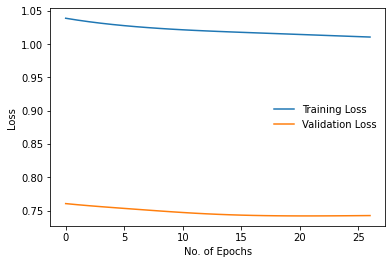

In [15]:
plt.plot(training_history['loss'],label="Training Loss")
plt.plot(validation_history['loss'],label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()